In [50]:
# LIBRARIES

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [51]:
# DATASET

df = pd.read_excel("DryBeanDataset/Dry_Bean_Dataset.xlsx")

#df.describe()
#df[df['Class']=='BOMBAY'].describe()

# FEATURES NAMES
'Area'
'Perimeter'
'MajorAxisLength'
'MinorAxisLength'
'AspectRation'
'Eccentricity'
'ConvexArea'
'EquivDiameter'
'Extent'
'Solidity'
'roundness'
'Compactness'
'ShapeFactor1'
'ShapeFactor2'
'ShapeFactor3'
'ShapeFactor4'


In [ ]:
# FEATURES CHECK

#Ed = np.sqrt(4 * df.loc[6453].Area / np.pi)
#Co = Ed / df.loc[6453].MajorAxisLength
#SF3 = df.loc[6453].Area / (np.pi * (df.loc[6453].MajorAxisLength / 2) * (df.loc[6453].MajorAxisLength / 2))

In [ ]:
# BOXPLOTS

#df.boxplot('Area', by='Class')

In [ ]:
# HISTOGRAMS

#df.hist(figsize=(20,15),bins=100)
#df.groupby('Class').hist(figsize=(20,15),bins=100)

C:\Users\damar\AppData\Local\Temp\ipykernel_9748\1330917693.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  CORR_MAP = df.corr().round(2)


<Axes: >

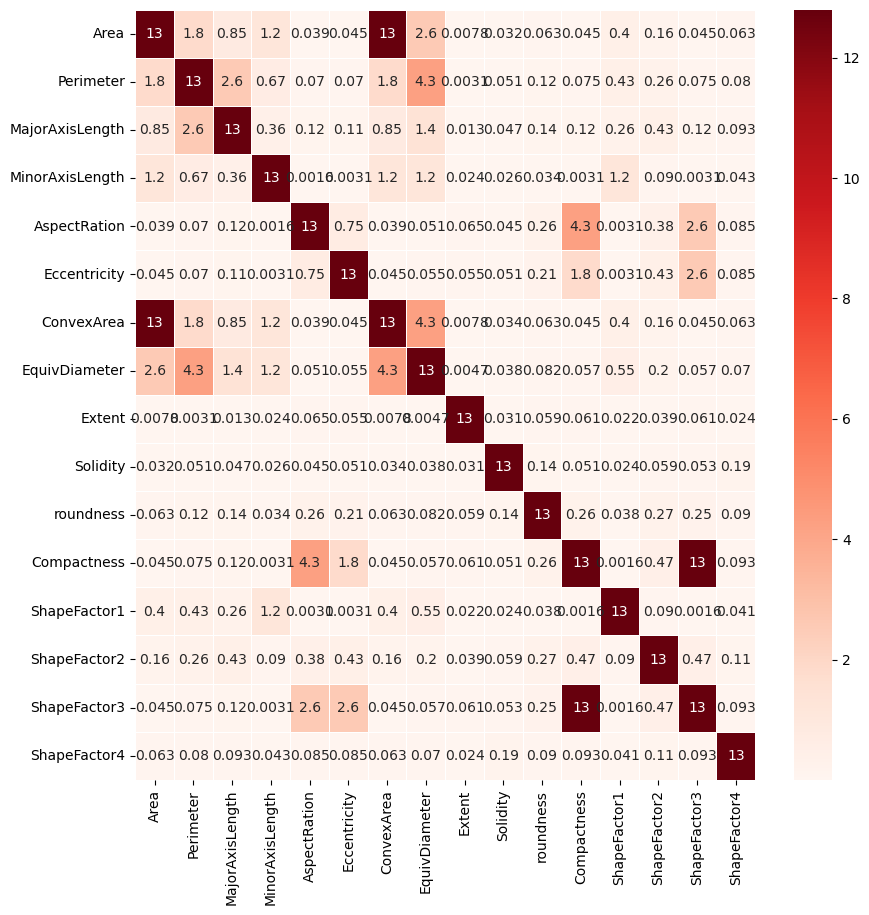

In [52]:
# CORRELATION
# Note: Area and ConvexArea are perfectly correlated: we already noticed that mathematically one is the square root of the other.
# Note: Compactness and Shape Factor 3 are perfectly correlated
# Proposition: Erase ConvexArea and Shape Factor 3

fig, ax = plt.subplots(figsize=(10,10)) 
CORR_MAP = df.corr().round(2)
Steepness = 10.0
ModIn1 = 2.01
if ModIn1 < 2.0 :
    ModIn1 = 2.0 
HIGH_CORR = (np.tan((np.pi/ModIn1) * np.abs(CORR_MAP)) * (1 / Steepness)) #LOW INFORMATION
LOW_CORR  = (np.tan((np.pi/ModIn1) * (1 - np.abs(CORR_MAP))) * (1 / Steepness)) #HIGH INFORMATION

sns.heatmap( HIGH_CORR ,annot=True,linewidths=.5, ax=ax, cmap='Reds')





